#**Import necessary libraries**

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import os
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
from PIL import Image
import pandas as pd
from lime import lime_image
import skimage.segmentation
from skimage.segmentation import mark_boundaries

2026-02-09 14:48:29.188140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770648509.382348      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770648509.438955      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770648509.924356      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770648509.924402      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770648509.924405      55 computation_placer.cc:177] computation placer alr

In [3]:
# pip install lime

## **Constant parameters**

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
SEED = 42
EPOCHS = 30
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
tf.random.set_seed(SEED)
np.random.seed(SEED)
tf.config.experimental.enable_op_determinism()

# **Dataset acquisition**

In [ ]:
# !unzip /content/drive/MyDrive/data/chest_xray.zip -d /content/drive/MyDrive/data
# %cd /content/drive/MyDrive/data/chest_xray
# %ls /content/drive/MyDrive/data/chest_xray

In [4]:
DATA_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')
class_names = [item for item in sorted(os.listdir(TRAIN_DIR)) if not item.startswith('.')]
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
num_classes = len(class_names)
print("class_index: ", class_to_idx)

print(f"\nClasses found: {class_names}")
print(f"Number of classes: {num_classes}")

def get_images_and_labels(dir):
  images = []
  labels = []
  for class_name in class_names:
    class_dir = os.path.join(dir, class_name)
    if not os.path.isdir(class_dir):
      print("Not found")
      continue

    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_dir, img_name)
            images.append(img_path)
            labels.append(class_to_idx[class_name])
  return np.array(images), np.array(labels)

train_images, train_labels = get_images_and_labels(TRAIN_DIR)
val_images, val_labels = get_images_and_labels(VAL_DIR)
test_images, test_labels = get_images_and_labels(TEST_DIR)


class_index:  {'NORMAL': 0, 'PNEUMONIA': 1}

Classes found: ['NORMAL', 'PNEUMONIA']
Number of classes: 2


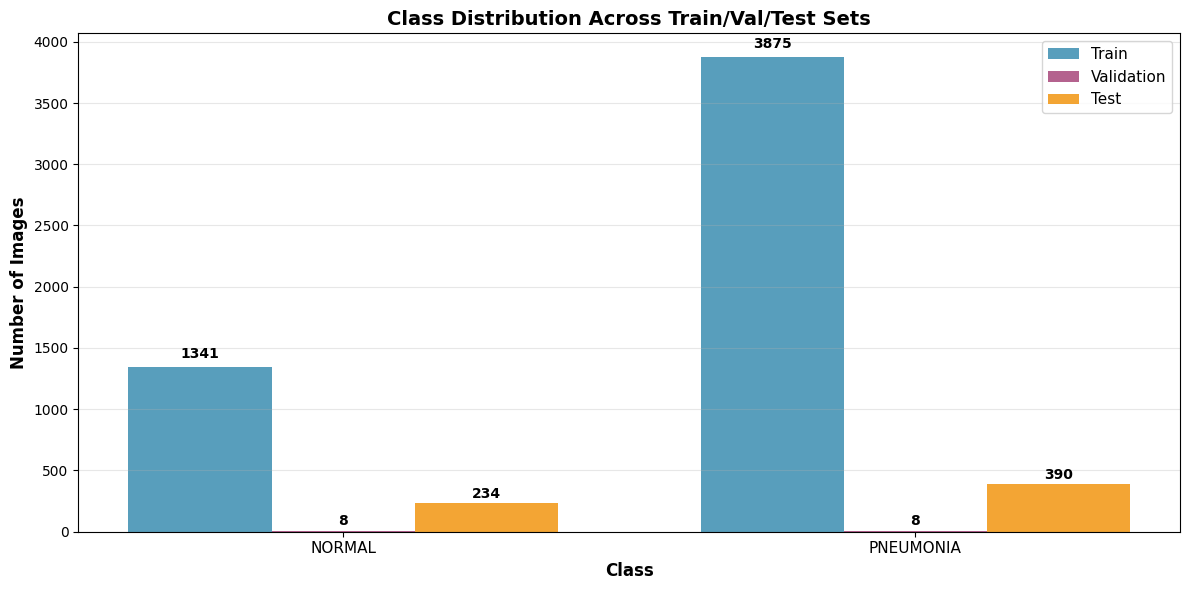

In [5]:
def plot_class_distribution(train_labels, val_labels, test_labels, class_names):
    """Plot class distribution across splits"""

    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)
    test_counts = Counter(test_labels)

    x = np.arange(len(class_names))
    width = 0.25

    train_vals = [train_counts[i] for i in range(len(class_names))]
    val_vals = [val_counts[i] for i in range(len(class_names))]
    test_vals = [test_counts[i] for i in range(len(class_names))]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(x - width, train_vals, width, label='Train', alpha=0.8, color='#2E86AB')
    ax.bar(x, val_vals, width, label='Validation', alpha=0.8, color='#A23B72')
    ax.bar(x + width, test_vals, width, label='Test', alpha=0.8, color='#F18F01')

    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Class Distribution Across Train/Val/Test Sets',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, (t, v, te) in enumerate(zip(train_vals, val_vals, test_vals)):
        ax.text(i - width, t + 50, str(t), ha='center', va='bottom', fontsize=10, fontweight='bold')
        ax.text(i, v + 20, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')
        ax.text(i + width, te + 20, str(te), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_class_distribution(train_labels, val_labels, test_labels, class_names)

From the graph above, we can see that:
1. Number of validation samples are too small (only 16 samples in total)
2. The dataset is imbalanced with more pneumonia samples. The ratio of pneumonia:normal in train dataset is approx. 3

Therefore, I will resplit the train dataset so that we have more samples for validation.

# **Resplit train dataset to get more validation samples**

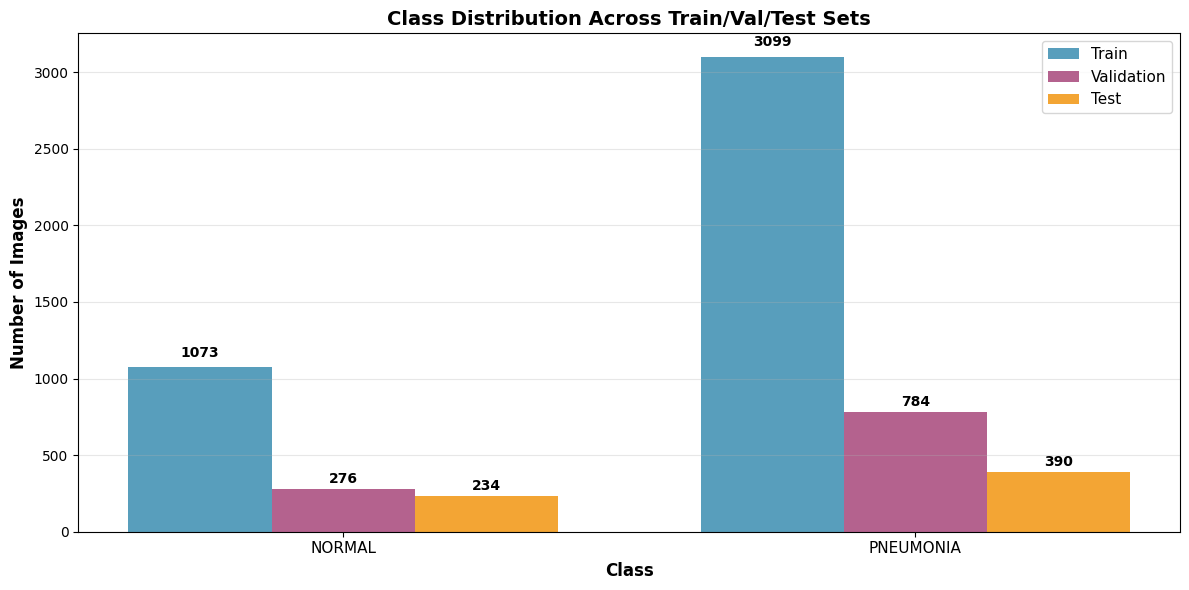

In [6]:
new_train_paths, new_val_paths, new_train_labels, new_val_labels = train_test_split(
    train_images,
    train_labels,
    test_size=(1 - TRAIN_SPLIT),  # 20% for validation
    stratify=train_labels,
    random_state=SEED
)

train_images = np.array(new_train_paths)
train_labels = np.array(new_train_labels)
val_images = np.concatenate((val_images, new_val_paths))
val_labels = np.concatenate((val_labels, new_val_labels))

plot_class_distribution(train_labels, val_labels, test_labels, class_names)

Now the ratio of train vs validation vs test dataset looks good. But the dataset is still imbalanced with more pneumonia samples than normal samples.

# **Preview the images**

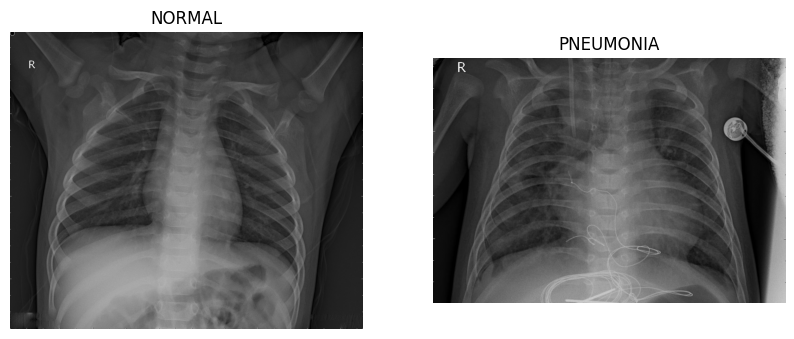

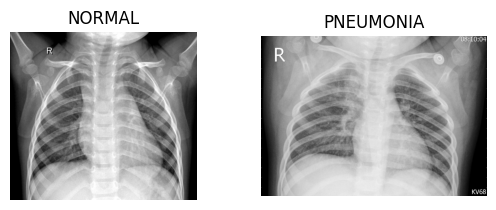

In [7]:
plt.figure(figsize=(10,6))
for j in range(2):
  for i, cls in enumerate(class_names):
      img_path = os.path.join(TRAIN_DIR, cls, os.listdir(os.path.join(TRAIN_DIR, cls))[j])
      img = Image.open(img_path)

      plt.subplot(j+1,2,i+1)
      plt.imshow(img, cmap="gray")
      plt.title(cls)
      plt.axis("off")

  plt.show()

The images have different scales and contrast.

# **My approach to build a high performance AI model to detect pneumonia**

**The current problems:**
1. Imbalanced dataset which can cause the model to have bias towards one class. In this case, pneumonia class have more samples so the model may predict the image as pneumonia most of the time.
2. Images with different illumination, contrast and scales (maybe due to different X-ray machine and image capturing technique of the doctors). This may lead to domain shift between train and test dataset.

**My proposed approach**:
1. First I will build a model with DenseNet21 as a base model and do transfer learning. DenseNet architecture is proved to perform well for Pneumonia Image Classification ([DenseNet21](https://www.mdpi.com/2078-2489/15/10/611)).
2. In order to solve the aforementioned problems, I will apply the following techniques one by one to confirm their effect on model accuracy improvement.


*   Data Augmentation (to tackle the imbalanced dataset problem)
*   Weighted Random Sampling (to tackle the imbalanced dataset problem)
*   Apply CLAHE (for enhancing local contrast) and noise reduction to images before feeding into the model (to provide richer feature representations for images)
*   Use XAI (explainable AI) to verify the decision made by the trained model.

After confirming the methods that can help improve the model accuracy, I will combine those methods together and retrain the model.


## **Functions for preprocessing images**

In [7]:
def apply_clahe_and_fuse(img):
    """
    Apply CLAHE, noise reduction, and edge detection to an image, then fuse the results.

    """
    # Step 1: Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(img)

    # Step 2: Apply noise reduction (Gaussian Blur)
    noise_reduced_image = cv2.GaussianBlur(img, (5, 5), 0)

    # Step 3: Fuse the images (stack along the last axis)
    fused_image = np.stack((img, clahe_image, noise_reduced_image), axis=-1)

    return fused_image

In [8]:
def preprocess_images(image_paths, target_size, clahe=False):
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, target_size)
        if clahe:
          fused_image = apply_clahe_and_fuse(img)
          images.append(fused_image)
        else:
          img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
          images.append(img_rgb)
    # Convert to NumPy array and normalize pixel values
    images = np.array(images, dtype="float32")
    # print('max before:', np.max(images),  np.min(images))
    images = preprocess_input(images)  # Apply DenseNet121 preprocessing
    # print('max after:', np.max(images),  np.min(images))
    return images


## **Build a model with DenseNet architecture**

In [9]:
def build_densenet_model(num_classes):

    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=INPUT_SHAPE,
        pooling='avg'
    )

    inputs = base_model.input
    x = base_model.output
    x = layers.Dropout(0.3, seed=SEED)(x)
    outputs = layers.Dense(1, activation='sigmoid', kernel_initializer=initializers.GlorotUniform(seed=SEED))(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="DenseNet121_Pneumonia")

    return model


## **Functions to plot training history**

In [10]:
def plot_training_history(history, model_name):
    """Plot training and validation metrics with custom X-axis steps"""
    num_epochs = len(history.history['accuracy'])

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='#2E86AB')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#A23B72')
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(np.arange(0, num_epochs, 2))
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, color='#2E86AB')
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='#A23B72')
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    axes[1].set_xticks(np.arange(0, num_epochs, 2))
    plt.tight_layout()
    plt.show()

    best_epoch = np.argmax(history.history['val_accuracy'])
    print(f"  - Best Epoch: {best_epoch + 1}")
    print(f"  - Train Accuracy: {history.history['accuracy'][best_epoch]:.4f}")
    print(f"  - Val Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
    print(f"  - Train Loss: {history.history['loss'][best_epoch]:.4f}")
    print(f"  - Val Loss: {history.history['val_loss'][best_epoch]:.4f}")


# **Function to optimize confidence threshold**

In [11]:
def find_optimal_confidence_threshold(model, pred_probs, test_labels):
  f_beta_scores = {}
  for confidence_threshold_i in np.arange(0.5, 0.99, 0.01): # Use np.arange for float steps
    confidence_threshold = confidence_threshold_i
    pred_labels = (pred_probs > confidence_threshold).astype(int).ravel()
    true_labels = test_labels

    #calculate f beta score
    f_beta_score = fbeta_score(true_labels, pred_labels, beta=2)
    f_beta_scores[confidence_threshold] = f_beta_score

  #sort f_beta_scores in descending order to find maximum f_beta_score
  f_beta_scores = dict(sorted(f_beta_scores.items(), key=lambda item: item[1], reverse=True))
  #return first key and item of f_beta_scores

  #plot keys on x axis and items on y axis
  plt.scatter(list(f_beta_scores.keys()), list(f_beta_scores.values()))
  return list(f_beta_scores.keys())[0], f_beta_scores[list(f_beta_scores.keys())[0]]

# **Function to train and validate the model using different techniques**
I set up the below function so that we can freely choose what technique to use during training, such as data augmentation, contrast enhancement and noise reduction, and class weighted training.

In [12]:
def train_and_validate_model(train_images, train_labels, val_images, val_labels, test_images, test_labels, num_classes, data_augmentation=True, CLAHE_noise_reduction=False, class_weight=False):
    model_dense = build_densenet_model(num_classes)

    model_dense.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    callbacks_dense = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1),
        keras.callbacks.ModelCheckpoint('best_densenet_pneumonia.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    model_dense.summary()

    if CLAHE_noise_reduction:
      print("Applying CLAHE (Contrast Limited Adaptive Histogram Equalization) and noise reduction method")
      train_images = preprocess_images(train_images, IMG_SIZE, clahe=True)
      val_images = preprocess_images(val_images, IMG_SIZE, clahe=True)
      test_images = preprocess_images(test_images, IMG_SIZE, clahe=True)
    else:
      train_images = preprocess_images(train_images, IMG_SIZE)
      val_images = preprocess_images(val_images, IMG_SIZE)
      test_images = preprocess_images(test_images, IMG_SIZE)

    if data_augmentation:
      print("Applying data augmentation method")
      #Shuffle the train dataset
      train_datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
              samplewise_center=False,  # set each sample mean to 0
              featurewise_std_normalization=False,  # divide inputs by std of the dataset
              samplewise_std_normalization=False,  # divide each input by its std
              zca_whitening=False,  # apply ZCA whitening
              rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
              zoom_range = 0.2, # Randomly zoom image
              width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
              height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
              horizontal_flip = True,  # randomly flip images
              vertical_flip=True)  # randomly flip images

      train_generator = train_datagen.flow(
          train_images,
          train_labels,
          batch_size=32,
          shuffle=True,  # Shuffle the dataset
          seed = SEED
      )

      #Do not shuffle val and test dataset
      valtest_datagen = ImageDataGenerator()
      val_generator = valtest_datagen.flow(
          val_images,
          val_labels,
          batch_size=32,
          shuffle=False,
          seed = SEED
      )
      test_generator = valtest_datagen.flow(
          test_images,
          test_labels,
          batch_size=32,
          shuffle=False,
          seed = SEED
      )
    else:
      train_generator = ImageDataGenerator().flow(train_images, train_labels, batch_size=32, shuffle=True)
      val_generator = ImageDataGenerator().flow(val_images, val_labels, batch_size=32, shuffle=False)
      test_generator = ImageDataGenerator().flow(test_images, test_labels, batch_size=32, shuffle=False)

    if class_weight:
      print("Applying class weighted training method")
      labels = []

      for i in range(len(train_generator)):
          _, y_batch = train_generator[i]  # Get the labels for each batch
          labels.extend(y_batch)

      class_weights_array = compute_class_weight(
          class_weight='balanced',
          classes=np.unique(labels),
          y=labels
      )

      class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

      print("Class Weights:", class_weights)
    else:
      class_weights = None

    history_dense = model_dense.fit(
      train_generator,
      validation_data=val_generator,
      epochs=EPOCHS,
      callbacks=callbacks_dense,
      verbose=1,
      class_weight=class_weights
    )

    plot_training_history(history_dense, "DenseNet121")

    return model_dense, test_generator

def test_model(model_dense, test_generator ):

    # Evaluate the model on the test set

    pred_probs = model_dense.predict(test_generator)
    true_labels = test_labels

    confidence_threshold, f_beta_score = find_optimal_confidence_threshold(model_dense, pred_probs, true_labels)
    print('Optimal confidence threshold: ', confidence_threshold)
    pred_labels = (pred_probs > confidence_threshold).astype(int).ravel()
    

    #confusion matrix
    cm_dense = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Greens',
              xticklabels=class_names,
              yticklabels=class_names,
              cbar_kws={'label': 'Count'},
              annot_kws={'size': 14, 'weight': 'bold'})

    plt.title('DenseNet121 - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\nClassification Report (DenseNet121):")
    print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))


    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC–AUC Curve (DenseNet121)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    return pred_probs


# **Train and Validate model with non-prepocessed train dataset and without any improvement techniques**

Model: "DenseNet121_Pneumonia"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9275 - loss: 0.1856
Epoch 1: val_accuracy improved from -inf to 0.51698, saving model to best_densenet_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 470ms/step - accuracy: 0.9277 - loss: 0.1852 - val_accuracy: 0.5170 - val_loss: 4.4739 - learning_rate: 0.0010
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9769 - loss: 0.0682
Epoch 2: val_accuracy improved from 0.51698 to 0.61604, saving model to best_densenet_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 58s 446ms/step - accuracy: 0.9769 - loss: 0.0681 - val_accuracy: 0.6160 - val_loss: 3.2759 - learning_rate: 0.0010
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9792 - loss: 0.0499
Epoch 3: val_accuracy improved from 0.61604 to 0.76038, saving model to best_densenet_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 434ms/step - accuracy: 0.9792 - loss: 0.0499 - val_accuracy: 0.7604 - val_loss: 1.2846 - learning_rate: 0.0010


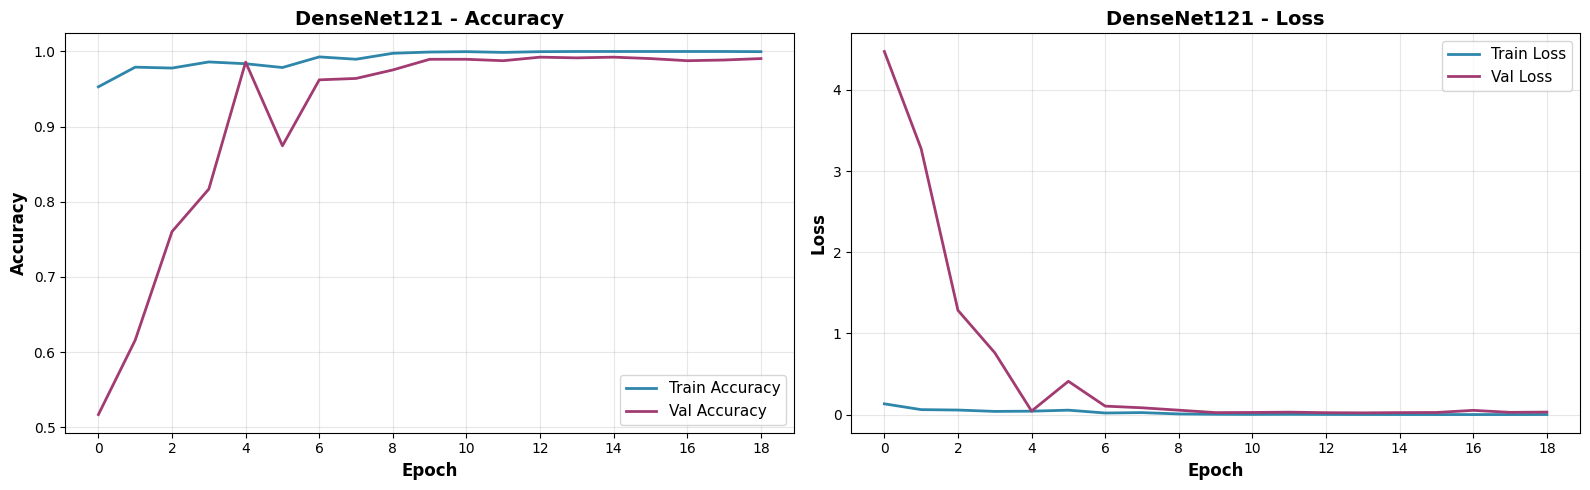

  - Best Epoch: 13
  - Train Accuracy: 0.9998
  - Val Accuracy: 0.9925
  - Train Loss: 0.0016
  - Val Loss: 0.0235


In [25]:
model_dense_0, test_generator_0 = train_and_validate_model(train_images, train_labels, val_images, val_labels, test_images, test_labels, num_classes, data_augmentation=False, CLAHE_noise_reduction=False, class_weight=False)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
Optimal confidence threshold:  0.9700000000000004


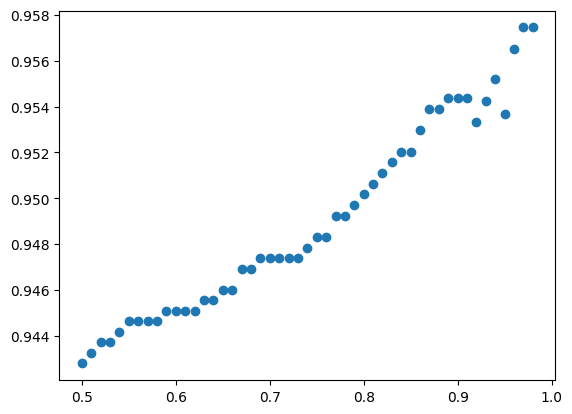

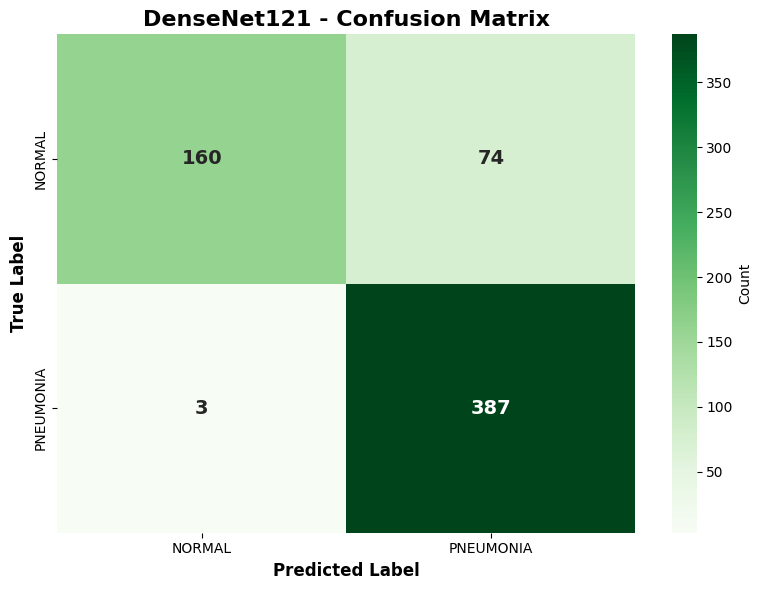


Classification Report (DenseNet121):
              precision    recall  f1-score   support

      NORMAL     0.9816    0.6838    0.8060       234
   PNEUMONIA     0.8395    0.9923    0.9095       390

    accuracy                         0.8766       624
   macro avg     0.9105    0.8380    0.8578       624
weighted avg     0.8928    0.8766    0.8707       624



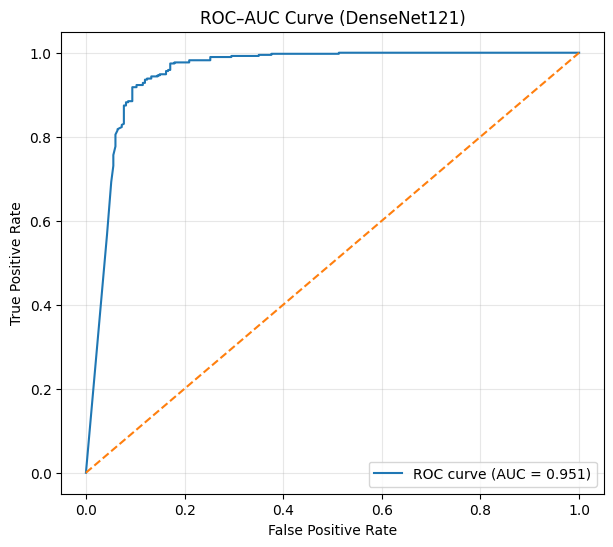

In [28]:
pred_probs_model_0 = test_model(model_dense_0, test_generator_0)

# **Train and Validate model with Data Augmentation only**

I0000 00:00:1770644362.758135      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "DenseNet121_Pneumonia"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Applying data augmentation method


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1770644539.690165     125 cuda_dnn.cc:529] Loaded cuDNN version 91002


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.8767 - loss: 0.2903
Epoch 1: val_accuracy improved from -inf to 0.27075, saving model to best_densenet_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 165s 734ms/step - accuracy: 0.8769 - loss: 0.2899 - val_accuracy: 0.2708 - val_loss: 16.9756 - learning_rate: 0.0010
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.9224 - loss: 0.1918
Epoch 2: val_accuracy improved from 0.27075 to 0.83868, saving model to best_densenet_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 694ms/step - accuracy: 0.9224 - loss: 0.1916 - val_accuracy: 0.8387 - val_loss: 0.5534 - learning_rate: 0.0010
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.9420 - loss: 0.1571
Epoch 3: val_accuracy did not improve from 0.83868
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 678ms/step - accuracy: 0.9420 - loss: 0.1570 - val_accuracy: 0.2925 - val_loss: 5.5487 - learning_rate: 0.0010
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accur

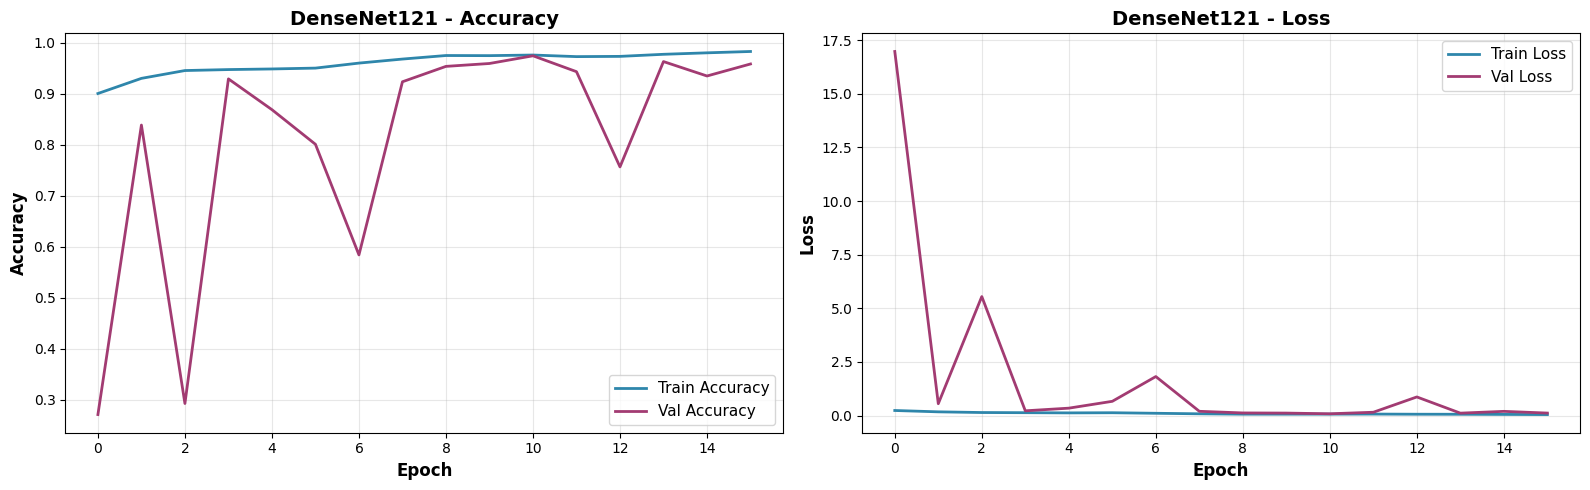

  - Best Epoch: 11
  - Train Accuracy: 0.9760
  - Val Accuracy: 0.9745
  - Train Loss: 0.0672
  - Val Loss: 0.0836


In [12]:
model_dense_1, test_generator_1 = train_and_validate_model(train_images, train_labels, val_images, val_labels, test_images, test_labels, num_classes, data_augmentation=True, CLAHE_noise_reduction=False, class_weight=False)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step
Optimal confidence threshold:  0.9300000000000004


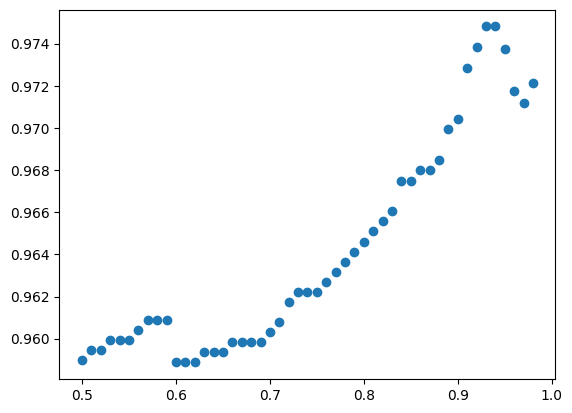

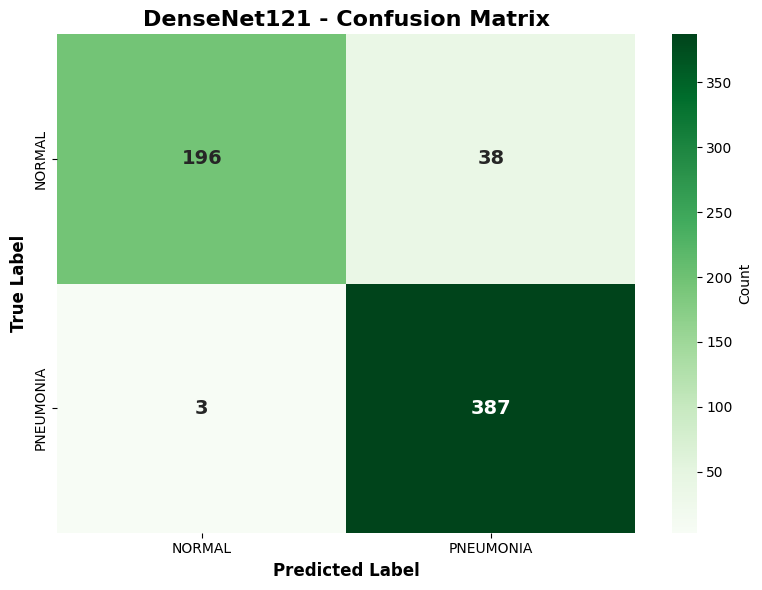


Classification Report (DenseNet121):
              precision    recall  f1-score   support

      NORMAL     0.9849    0.8376    0.9053       234
   PNEUMONIA     0.9106    0.9923    0.9497       390

    accuracy                         0.9343       624
   macro avg     0.9478    0.9150    0.9275       624
weighted avg     0.9385    0.9343    0.9331       624



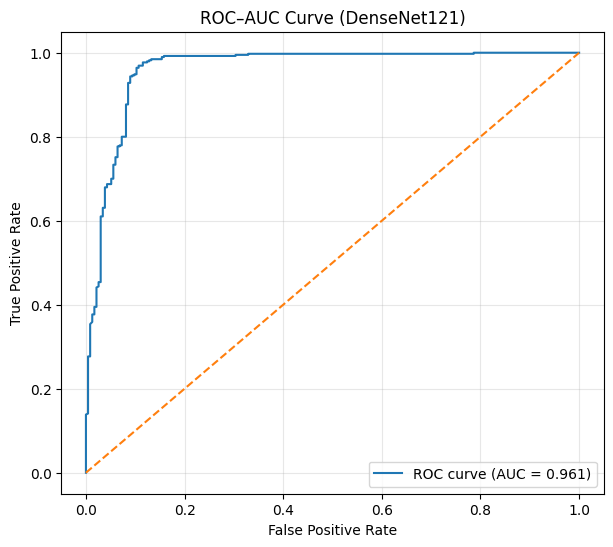

In [13]:
pred_probs_model_1 = test_model(model_dense_1, test_generator_1)

# **Train and Validate model with Data Augmentation, CLAHE and noise reduction**

I0000 00:00:1770642891.236665      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "DenseNet121_Pneumonia"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Applying CLAHE (Contrast Limited Adaptive Histogram Equalization) and noise reduction method
Applying data augmentation method


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1770643069.216114     125 cuda_dnn.cc:529] Loaded cuDNN version 91002


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.8735 - loss: 0.3164
Epoch 1: val_accuracy improved from -inf to 0.46887, saving model to best_densenet_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 165s 738ms/step - accuracy: 0.8738 - loss: 0.3159 - val_accuracy: 0.4689 - val_loss: 1.5471 - learning_rate: 0.0010
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.9275 - loss: 0.1707
Epoch 2: val_accuracy improved from 0.46887 to 0.63396, saving model to best_densenet_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 693ms/step - accuracy: 0.9276 - loss: 0.1706 - val_accuracy: 0.6340 - val_loss: 1.5517 - learning_rate: 0.0010
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.9449 - loss: 0.1440
Epoch 3: val_accuracy improved from 0.63396 to 0.93962, saving model to best_densenet_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 693ms/step - accuracy: 0.9449 - loss: 0.1440 - val_accuracy: 0.9396 - val_loss: 0.1719 - learning_rate: 0.0010
Epoch 4/30


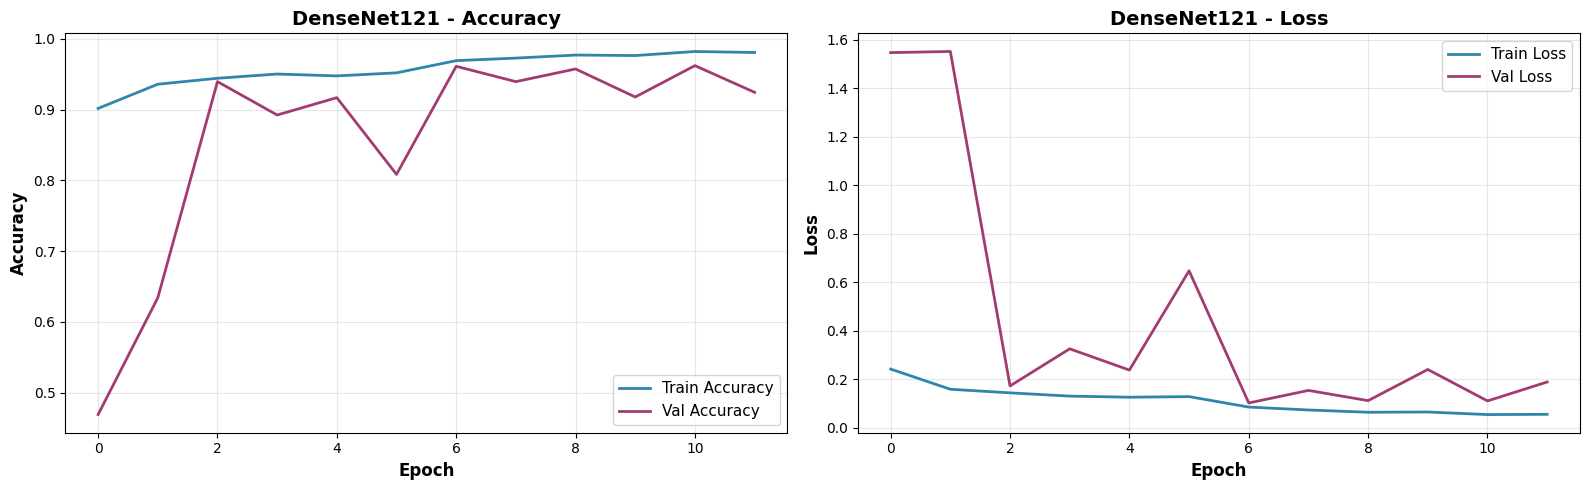

  - Best Epoch: 11
  - Train Accuracy: 0.9823
  - Val Accuracy: 0.9623
  - Train Loss: 0.0536
  - Val Loss: 0.1099


In [12]:
model_dense_2, test_generator_2  = train_and_validate_model(train_images, train_labels, val_images, val_labels, test_images, test_labels, num_classes, data_augmentation=True, CLAHE_noise_reduction=True, class_weight=False)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step
Optimal confidence threshold:  0.6600000000000001


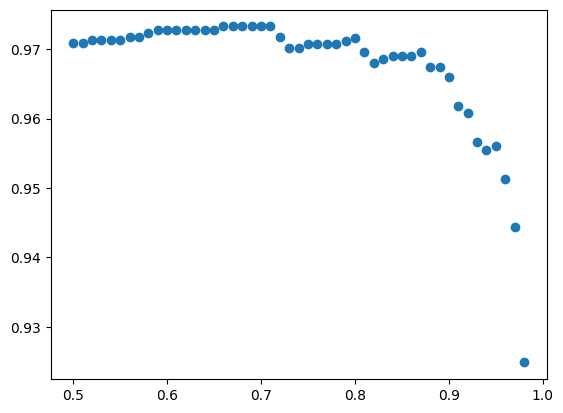

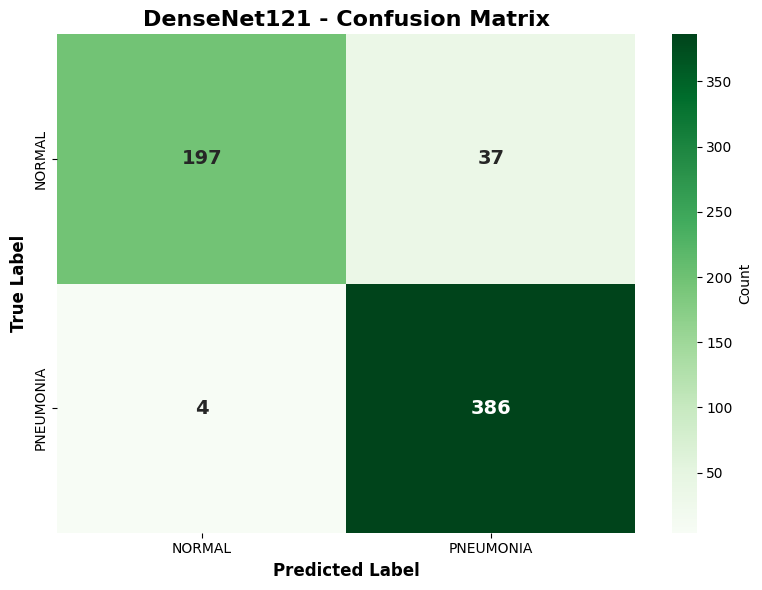


Classification Report (DenseNet121):
              precision    recall  f1-score   support

      NORMAL     0.9801    0.8419    0.9057       234
   PNEUMONIA     0.9125    0.9897    0.9496       390

    accuracy                         0.9343       624
   macro avg     0.9463    0.9158    0.9277       624
weighted avg     0.9379    0.9343    0.9331       624



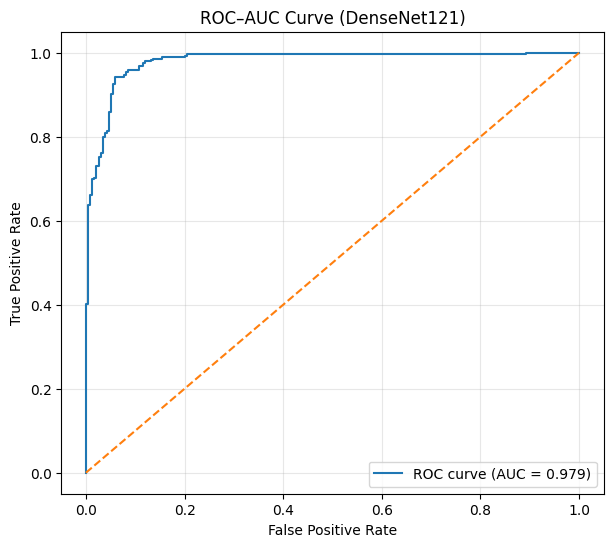

In [14]:
pred_probs_model_2 = test_model(model_dense_2, test_generator_2)

# **Train and Validate model with Data Augmentation and class weighted training**

I0000 00:00:1770646345.948597      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "DenseNet121_Pneumonia"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Applying data augmentation method
Applying class weighted training method
Class Weights: {0: np.float64(1.9440820130475303), 1: np.float64(0.6731203614069055)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1770646524.726870     124 cuda_dnn.cc:529] Loaded cuDNN version 91002


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8264 - loss: 0.4042
Epoch 1: val_accuracy improved from -inf to 0.86038, saving model to best_densenet_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 164s 739ms/step - accuracy: 0.8267 - loss: 0.4034 - val_accuracy: 0.8604 - val_loss: 4.0176 - learning_rate: 0.0010
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9246 - loss: 0.1914
Epoch 2: val_accuracy did not improve from 0.86038
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 687ms/step - accuracy: 0.9246 - loss: 0.1915 - val_accuracy: 0.3047 - val_loss: 6.8862 - learning_rate: 0.0010
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.9274 - loss: 0.1857
Epoch 3: val_accuracy did not improve from 0.86038
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 683ms/step - accuracy: 0.9274 - loss: 0.1857 - val_accuracy: 0.3406 - val_loss: 3.4087 - learning_rate: 0.0010
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.9369 - loss: 0.1662
Epoch 4: val_accuracy did

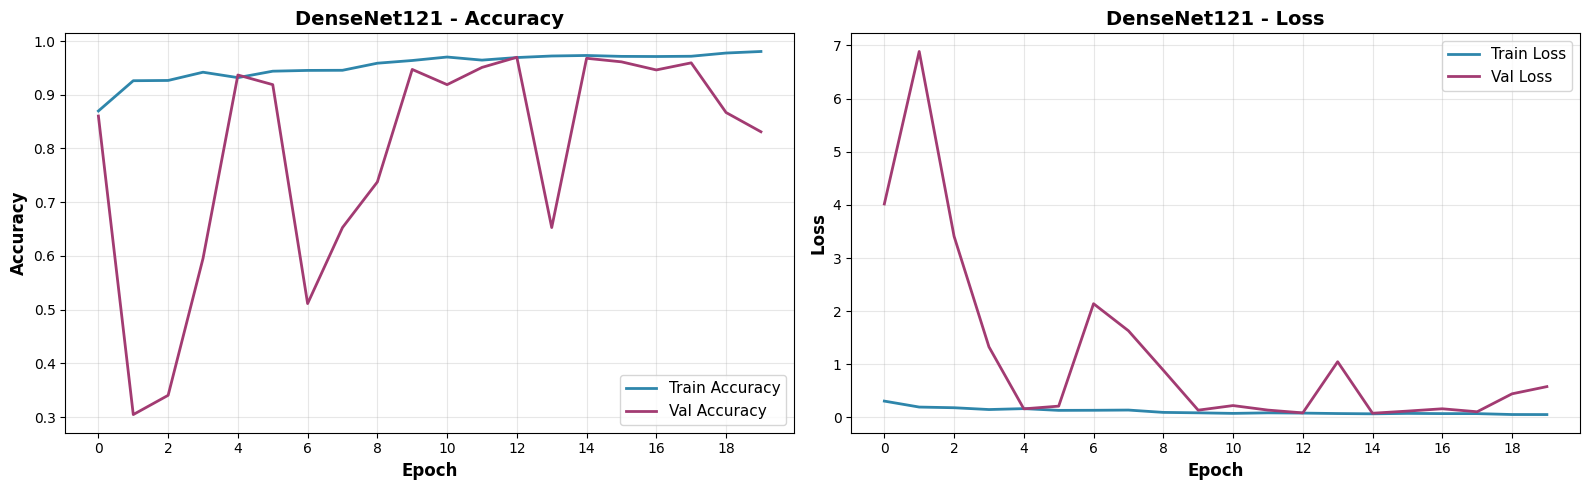

  - Best Epoch: 13
  - Train Accuracy: 0.9693
  - Val Accuracy: 0.9698
  - Train Loss: 0.0826
  - Val Loss: 0.0865


In [17]:
model_dense_3, test_generator_3  = train_and_validate_model(train_images, train_labels, val_images, val_labels, test_images, test_labels, num_classes, data_augmentation=True, CLAHE_noise_reduction=False, class_weight=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step
Optimal confidence threshold:  0.8100000000000003


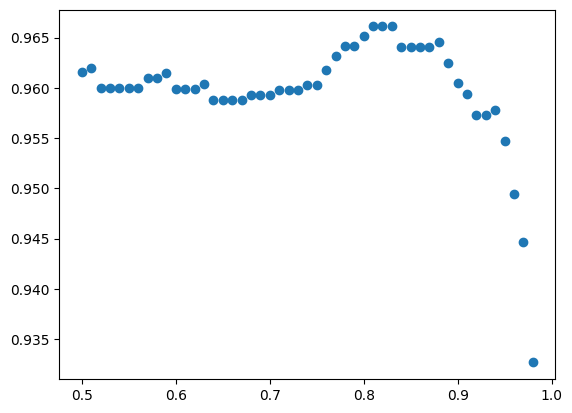

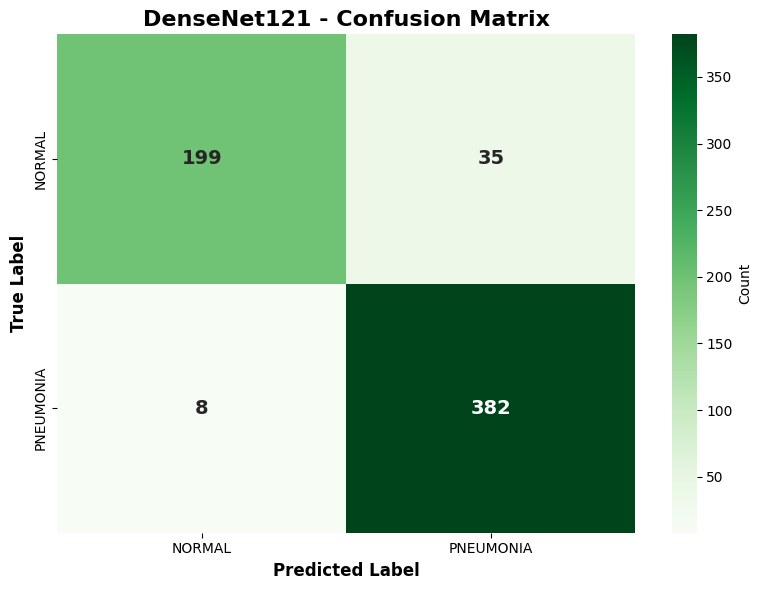


Classification Report (DenseNet121):
              precision    recall  f1-score   support

      NORMAL     0.9614    0.8504    0.9025       234
   PNEUMONIA     0.9161    0.9795    0.9467       390

    accuracy                         0.9311       624
   macro avg     0.9387    0.9150    0.9246       624
weighted avg     0.9330    0.9311    0.9301       624



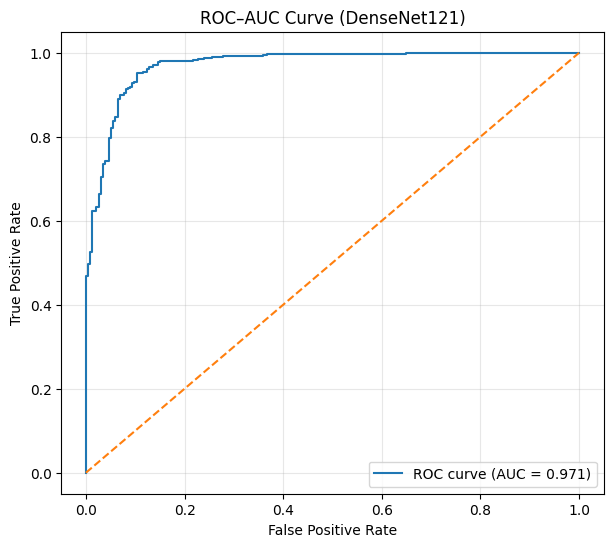

In [18]:
pred_probs_model_3 = test_model(model_dense_3, test_generator_3)

# **Train and validate the model with data augmentation, CLAHE, noise reduction and class weighted training method**

I0000 00:00:1770648525.271755      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "DenseNet121_Pneumonia"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Applying CLAHE (Contrast Limited Adaptive Histogram Equalization) and noise reduction method
Applying data augmentation method
Applying class weighted training method
Class Weights: {0: np.float64(1.9440820130475303), 1: np.float64(0.6731203614069055)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1770648729.911820     125 cuda_dnn.cc:529] Loaded cuDNN version 91002


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.8467 - loss: 0.3620
Epoch 1: val_accuracy improved from -inf to 0.35472, saving model to best_densenet_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 170s 746ms/step - accuracy: 0.8470 - loss: 0.3614 - val_accuracy: 0.3547 - val_loss: 5.4293 - learning_rate: 0.0010
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.9113 - loss: 0.1962
Epoch 2: val_accuracy improved from 0.35472 to 0.43774, saving model to best_densenet_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 92s 706ms/step - accuracy: 0.9114 - loss: 0.1961 - val_accuracy: 0.4377 - val_loss: 5.1397 - learning_rate: 0.0010
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.9240 - loss: 0.1804
Epoch 3: val_accuracy did not improve from 0.43774
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 690ms/step - accuracy: 0.9240 - loss: 0.1803 - val_accuracy: 0.4038 - val_loss: 3.1029 - learning_rate: 0.0010
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accura

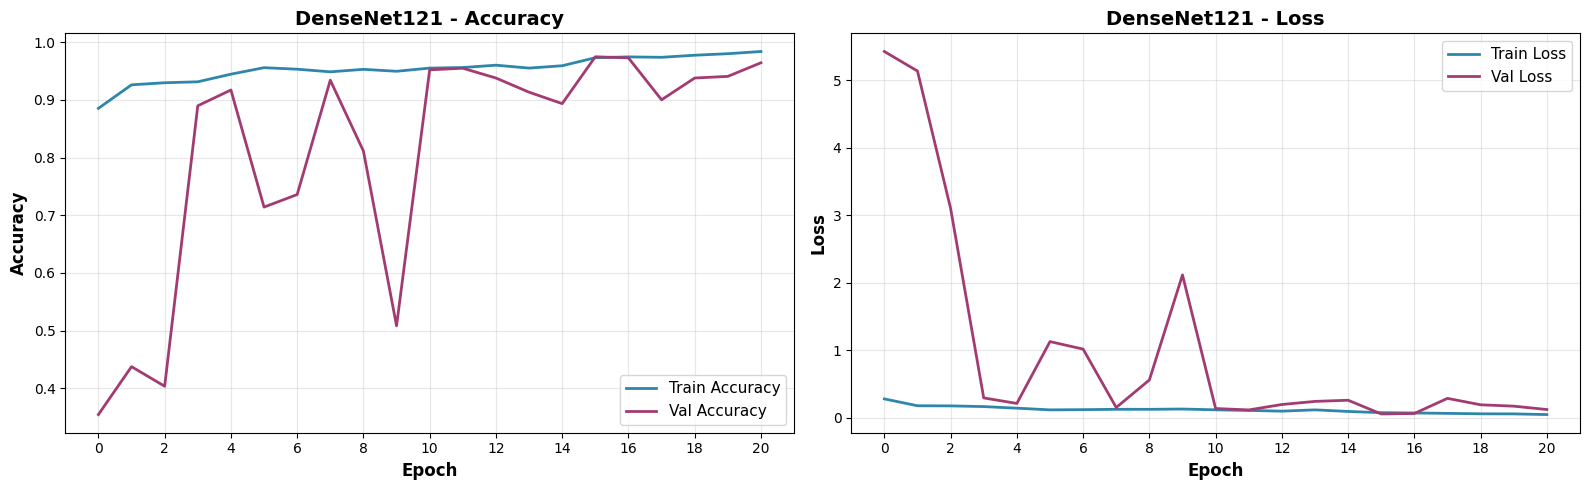

  - Best Epoch: 16
  - Train Accuracy: 0.9729
  - Val Accuracy: 0.9745
  - Train Loss: 0.0739
  - Val Loss: 0.0551


In [13]:
model_dense_4, test_generator_4  = train_and_validate_model(train_images, train_labels, val_images, val_labels, test_images, test_labels, num_classes, data_augmentation=True, CLAHE_noise_reduction=True, class_weight=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step
Optimal confidence threshold:  0.8300000000000003


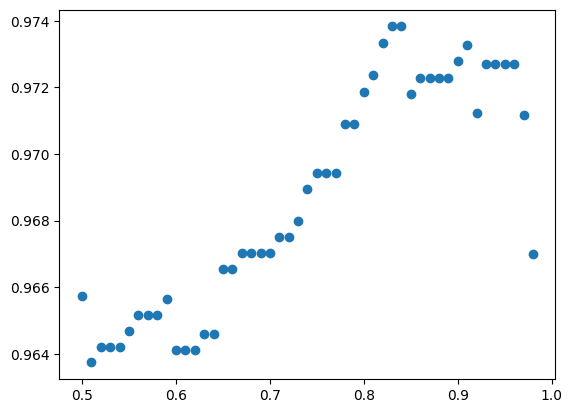

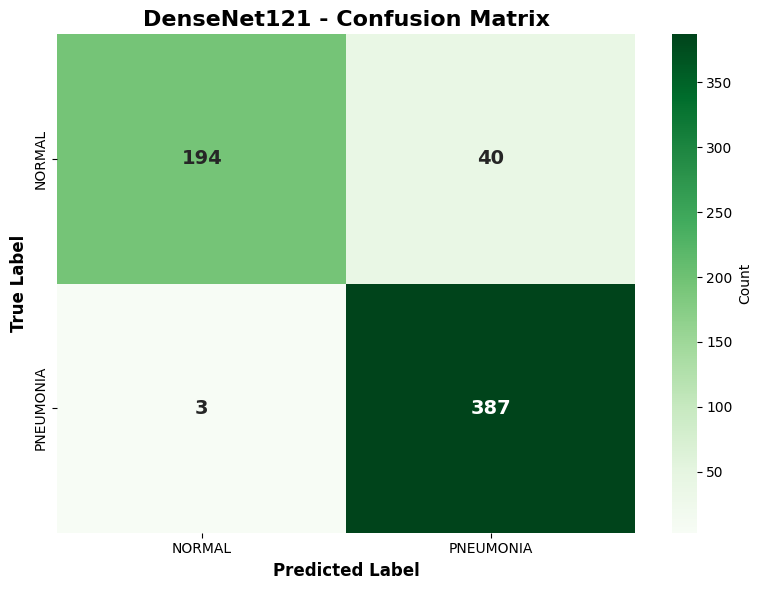


Classification Report (DenseNet121):
              precision    recall  f1-score   support

      NORMAL     0.9848    0.8291    0.9002       234
   PNEUMONIA     0.9063    0.9923    0.9474       390

    accuracy                         0.9311       624
   macro avg     0.9455    0.9107    0.9238       624
weighted avg     0.9357    0.9311    0.9297       624



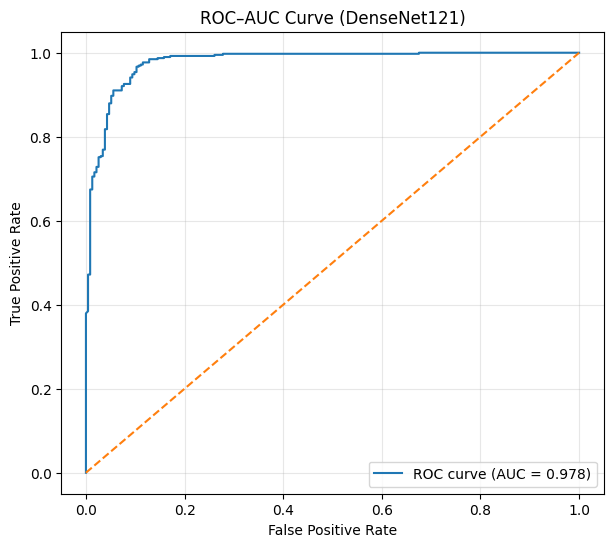

In [14]:
pred_probs_model_4 = test_model(model_dense_4, test_generator_4)

# **Model comparison**

To compare these 4 models, I will focus on 4 key metrics:
*   Recall: Most critical in medical screening—minimizes missed pneumonia cases.
*   Precision: Important to avoid unnecessary follow-ups from false positives.
*   F1 Score: Balances recall and precision, especially useful for imbalanced data.
*   AUC: Measures overall discrimination, robust to class imbalance.

I will calculate a weighted score to reflect clinical priorities (e.g., recall and AUC are most important).

*   Weights Example: AUC (40%), Recall (35%), F1 (15%), Precision (10%)
*   Interpretation: The model with the highest clinical priority score is best for minimizing missed pneumonia cases.




In [50]:
data = {
    'AUC score': [0.951, 0.961, 0.976, 0.971, 0.978],
    'Pneumonia Precision': [0.8395, 0.9106, 0.9364, 0.9161, 0.9063],
    'Pneumonia Recall': [ 0.9923, 0.9923, 0.9821, 0.9795, 0.9923],
    'Pneumonia F1 Score': [0.9095,  0.9497, 0.9587, 0.9467, 0.9474]
}

model_names = [
    'Model 0 (No Augmentation, only DenseNet121 and custom layer)',
    'Model 1 (Data Augmentation Only)',
    'Model 2 (DA + CLAHE + Noise Reduction)',
    'Model 3 (Data Augmentation + Class Weighting)',
    'Model 4 (DA + CLAHE + Noise Reduction + Class Weighting)'
]

df = pd.DataFrame(data, index=model_names)
display(df)

AUC score  \
Model 0 (No Augmentation, only DenseNet121 and ...      0.951   
Model 1 (Data Augmentation Only)                        0.961   
Model 2 (DA + CLAHE + Noise Reduction)                  0.976   
Model 3 (Data Augmentation + Class Weighting)           0.971   
Model 4 (DA + CLAHE + Noise Reduction + Class W...      0.978   

                                                    Pneumonia Precision  \
Model 0 (No Augmentation, only DenseNet121 and ...               0.8395   
Model 1 (Data Augmentation Only)                                 0.9106   
Model 2 (DA + CLAHE + Noise Reduction)                           0.9364   
Model 3 (Data Augmentation + Class Weighting)                    0.9161   
Model 4 (DA + CLAHE + Noise Reduction + Class W...               0.9063   

                                                    Pneumonia Recall  \
Model 0 (No Augmentation, only DenseNet121 and ...            0.9923   
Model 1 (Data Augmentation Only)                              0.9923   
Model 2 (DA + CLAHE + Noise Reduction)                        0.9821   
Model 3 (Data Augmentation + Class Weighting)                 0.9795   
Model 4 (DA + CLAHE + Noise Reduction + Class W...            0.9923   

                                                    Pneumonia F1 Score  
Model 0 (No Augmentation, only DenseNet121 and ...              0.9095  
Model 1 (Data Augmentation Only)                                0.9497  
Model 2 (DA + CLAHE + Noise Reduction)                          0.9587  
Model 3 (Data Augmentation + Class Weighting)                   0.9467  
Model 4 (DA + CLAHE + Noise Reduction + Class W...              0.9474

AUC score  \
Model 2 (DA + CLAHE + Noise Reduction)                  0.976   
Model 4 (DA + CLAHE + Noise Reduction + Class W...      0.978   
Model 1 (Data Augmentation Only)                        0.961   
Model 3 (Data Augmentation + Class Weighting)           0.971   
Model 0 (No Augmentation, only DenseNet121 and ...      0.951   

                                                    Pneumonia Precision  \
Model 2 (DA + CLAHE + Noise Reduction)                           0.9364   
Model 4 (DA + CLAHE + Noise Reduction + Class W...               0.9063   
Model 1 (Data Augmentation Only)                                 0.9106   
Model 3 (Data Augmentation + Class Weighting)                    0.9161   
Model 0 (No Augmentation, only DenseNet121 and ...               0.8395   

                                                    Pneumonia Recall  \
Model 2 (DA + CLAHE + Noise Reduction)                        0.9821   
Model 4 (DA + CLAHE + Noise Reduction + Class W...            0.9923   
Model 1 (Data Augmentation Only)                              0.9923   
Model 3 (Data Augmentation + Class Weighting)                 0.9795   
Model 0 (No Augmentation, only DenseNet121 and ...            0.9923   

                                                    Pneumonia F1 Score  \
Model 2 (DA + CLAHE + Noise Reduction)                          0.9587   
Model 4 (DA + CLAHE + Noise Reduction + Class W...              0.9474   
Model 1 (Data Augmentation Only)                                0.9497   
Model 3 (Data Augmentation + Class Weighting)                   0.9467   
Model 0 (No Augmentation, only DenseNet121 and ...              0.9095   

                                                    Weighted Score  
Model 2 (DA + CLAHE + Noise Reduction)                    0.971580  
Model 4 (DA + CLAHE + Noise Reduction + Class W...        0.971245  
Model 1 (Data Augmentation Only)                          0.965220  
Model 3 (Data Augmentation + Class Weighting)             0.964840  
Model 0 (No Augmentation, only DenseNet121 and ...        0.948080

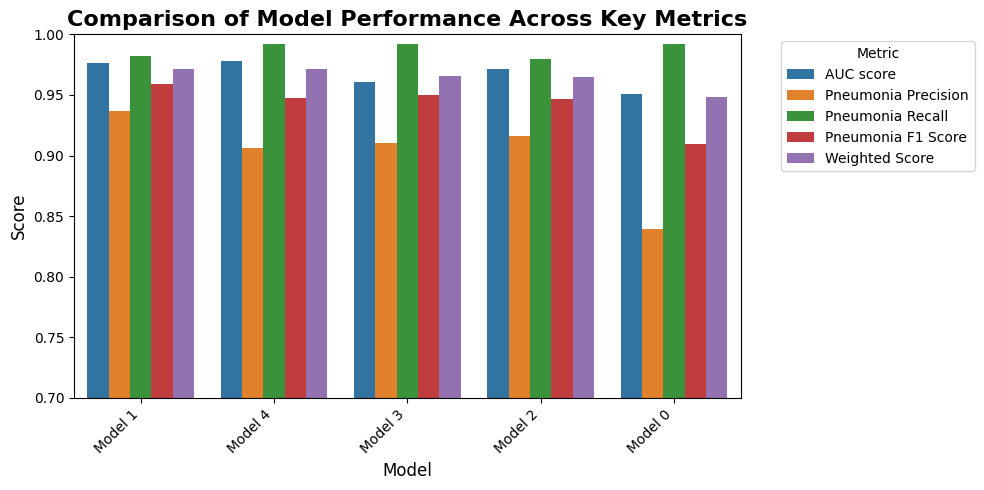

In [51]:
df['Weighted Score'] = (
    df['AUC score'] * 0.4 +
    df['Pneumonia Recall'] * 0.35 +
    df['Pneumonia F1 Score'] * 0.15 +
    df['Pneumonia Precision'] * 0.1
)
df_sorted = df.sort_values(by='Weighted Score', ascending=False)
display(df_sorted)


# Melt the DataFrame to long format for easier plotting of multiple metrics
df_melted = df_sorted.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
df_melted = df_melted.rename(columns={'index': 'Model'})

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, palette='tab10')

plt.title('Comparison of Model Performance Across Key Metrics', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.7, 1.0) # Set a consistent y-axis limit for better comparison of scores (assuming scores are typically between 0 and 1)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
#change x tick label
new_labels = ['Model 1', 'Model 4', 'Model 3', 'Model 2', 'Model 0']
plt.xticks(range(len(new_labels)), new_labels)
plt.tight_layout()
plt.show()

From the comparison table above, Model 1 has the best performance overall (highest weighted score).

# **Visualize fused images**

In [ ]:
# ImageNet mean and std for RGB
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def denormalize_img(img_norm):
    img = img_norm * std + mean
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]
    img = (img * 255).astype(np.uint8)
    return img

# # Example usage:
# images_a  = preprocess_images(test_images, IMG_SIZE, clahe=True)
# img_norm = images_a[0]  # shape (H, W, 3)
# img_disp = denormalize_img(img_norm)
# plt.imshow(img_disp)
# plt.title('Pneumonia' if test_labels[0]==1 else 'Normal')
# plt.axis('off')
# plt.show()

In [ ]:
# img_norm = images_a[-1]  # shape (H, W, 3)
# img_disp = denormalize_img(img_norm)
# plt.imshow(img_disp)
# plt.title('Pneumonia' if test_labels[-1]==1 else 'Normal')
# plt.axis('off')
# plt.show()

# **XAI**
CNN visualization to verify the decision made by the model. I will use GradCAM for the positive (Pneumonia) class to highlight abnormalities.

In [17]:
#Load model_2.leras
model_2 = keras.models.load_model('/kaggle/input/densenet121-with-custom-layers/tensorflow2/default/1/model_2.keras')

In [18]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get the last conv layer
    img_array = np.expand_dims(img_array, axis=0)
    print('Input Image shape: ', img_array.shape)

    grad_model = tf.keras.models.Model(
        model.input,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the output neuron with respect to the last conv layer output
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img_array]) # Wrap img_array in a list to match the expected input structure
        print(f"Model prediction: {predictions.numpy()}")
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # For binary classification, output is shape (1, 1)
        output = predictions[:, pred_index]
    grads = tape.gradient(output, conv_outputs)
    print(f"Gradients shape: {grads.shape}")
    print(f"Gradients mean: {tf.reduce_mean(grads).numpy()}")
    if tf.reduce_mean(grads).numpy() < 0.01:
      grads = grads * 100
    # Compute the guided gradients (global average pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the conv layer outputs by the pooled gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    print('Heatmap: ', heatmap)
    # Add a small epsilon to the denominator to avoid division by zero
    # Also, ensure only positive values are kept (standard for Grad-CAM with ReLU)
    heatmap = tf.maximum(heatmap, 0)
    max_heatmap_value = tf.math.reduce_max(heatmap)
    print(f'Max heatmap value before normalization: {max_heatmap_value.numpy():.4f}')
    if max_heatmap_value == 0:
        # If max is 0, the heatmap is all zeros, return it as is to avoid division by zero
        heatmap = heatmap
    else:
        heatmap = heatmap / (max_heatmap_value + tf.keras.backend.epsilon()) # Add epsilon

    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4, cmap='jet'): # Increased alpha to 0.7

    # Display raw heatmap first to check its content
    # plt.figure(figsize=(8, 8))
    # plt.imshow(heatmap, cmap=cmap)
    # plt.title('Raw Heatmap (before superimposition)')
    # plt.axis('off')
    # plt.show()

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = plt.get_cmap(cmap)(heatmap_resized)
    heatmap_colored = np.uint8(255 * heatmap_colored[..., :3])

    # Superimpose heatmap on image
    if img.max() <= 1.0:
        img_disp = np.uint8(255 * img)
    else:
        img_disp = img.copy()
    superimposed_img = cv2.addWeighted(img_disp, 1 - alpha, heatmap_colored, alpha, 0)

    # Display superimposed image
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title('Grad-CAM')
    plt.show()


def gradcam_on_image(idx, img_paths, model, processed_test_images, IMG_SIZE):
    """
    Loads an image, preprocesses it, computes Grad-CAM, and displays the result.
    """
    # Load and preprocess image
    img = cv2.imread(img_paths[idx])

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)

    img_array = processed_test_images[idx]

    print('Img arrays shape: ', img_array.shape)
    # Compute Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(
        img_array,
        model,
        last_conv_layer_name='conv5_block16_concat'
    )

    # Display Grad-CAM
    display_gradcam(img_resized, heatmap)


In [33]:
processed_test_images = preprocess_images(test_images, IMG_SIZE, clahe=True)


In [34]:
pred_probs = model_2.predict(processed_test_images)
pred_labels = (pred_probs > 0.66).astype(int).ravel()
true_labels = test_labels
#find the indices where value in preb_labels is 0 and value in true labels is 1
false_negative_cases = np.where((pred_labels == 0) & (true_labels == 1))[0]

#find the indices where value in preb_labels is 1 and value in true labels is 1
true_positive_cases = np.where((pred_labels == 1) & (true_labels == 1))[0]

 1/20 ━━━━━━━━━━━━━━━━━━━━ 7s 403ms/step

2026-02-09 15:46:08.538860: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


In [35]:
false_negative_cases

array([245, 291, 373, 462, 544, 547, 584])

In [36]:
true_positive_cases[:10]

array([234, 235, 236, 237, 238, 239, 240, 241, 242, 243])

Img arrays shape:  (224, 224, 3)
Input Image shape:  (1, 224, 224, 3)
Model prediction: [[0.99886274]]


W0000 00:00:1770651696.985977      55 conv_ops_gpu.cc:328] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 1
in_depths: 3
out_depths: 64
in: 230
in: 230
data_format: 1
filter: 7
filter: 7
filter: 3
dilation: 1
dilation: 1
stride: 2
stride: 2
padding: 0
padding: 0
dtype: DT_FLOAT
group_count: 1
device_identifier: "sm_6.0 with 17059545088B RAM, 56 cores, 1328500KHz clock, 715000KHz mem clock, 4194304B L2$"
version: 3



Gradients shape: (1, 7, 7, 1024)
Gradients mean: 9.370247653350816e-07
Heatmap:  tf.Tensor(
[[-2.03927997e-02 -2.31060479e-02 -1.49334129e-02 -1.39514124e-02
  -1.19495867e-02 -1.30817071e-02 -8.50462448e-03]
 [-1.32221412e-02 -1.27821201e-02  1.49380951e-03  6.59420760e-03
   3.66061251e-03 -7.71325780e-03 -6.84525026e-03]
 [-5.16392570e-03  4.39268397e-03  2.40858626e-02  3.40291411e-02
   2.30660848e-02  2.00555217e-03 -5.32175926e-03]
 [-5.36461873e-03  8.15469027e-03  3.03090066e-02  4.52859513e-02
   3.00852675e-02  7.02867843e-03 -5.60292322e-03]
 [-6.00697333e-03  4.85954806e-03  2.41725277e-02  4.22494635e-02
   3.00675333e-02  9.44176689e-03 -5.91715705e-03]
 [-5.68778114e-03 -6.91297464e-05  1.40956016e-02  2.80917138e-02
   2.05016322e-02  4.91698226e-03 -5.54330926e-03]
 [-4.66497941e-03 -2.57290760e-03  6.05551805e-03  1.31042665e-02
   9.35042929e-03  2.54043960e-03 -4.41742269e-03]], shape=(7, 7), dtype=float32)
Max heatmap value before normalization: 0.0453


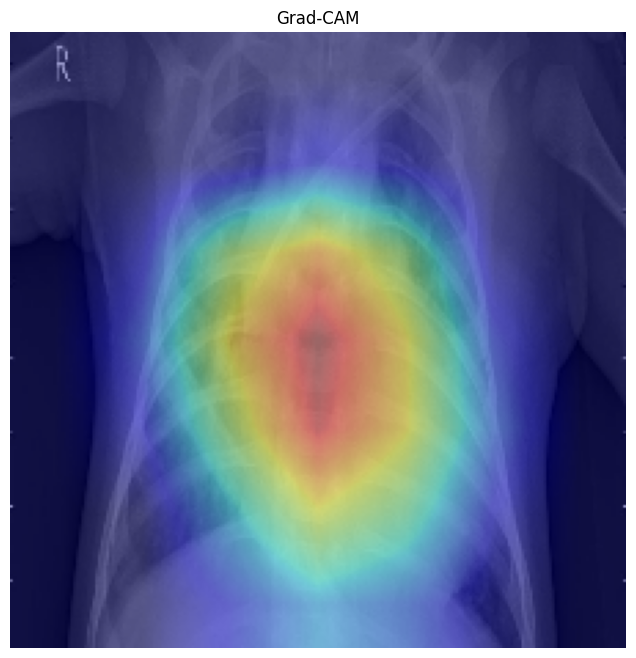

In [25]:
gradcam_on_image(237, test_images, model_2, processed_test_images, IMG_SIZE)

(np.float64(-0.5), np.float64(983.5), np.float64(519.5), np.float64(-0.5))

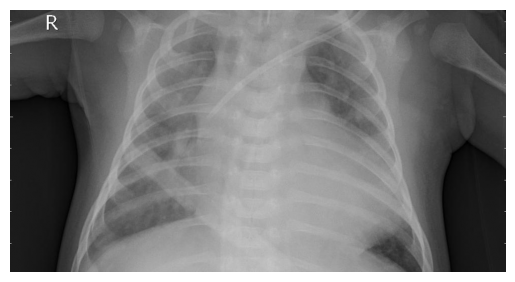

In [26]:
img = Image.open(test_images[237])

plt.imshow(img, cmap="gray")
plt.axis("off")

Img arrays shape:  (224, 224, 3)
Input Image shape:  (1, 224, 224, 3)
Model prediction: [[0.99096596]]
Gradients shape: (1, 7, 7, 1024)
Gradients mean: 6.039005711500067e-06
Heatmap:  tf.Tensor(
[[-0.02080386 -0.09254728 -0.1891567  -0.18683766 -0.11073156 -0.09070797
  -0.14109726]
 [-0.02585468 -0.1232206  -0.17036825 -0.09471136 -0.0248992  -0.05151958
  -0.14051285]
 [-0.04960708 -0.09224805 -0.03347628  0.10853592  0.1464932   0.04337792
  -0.07807332]
 [-0.04520888 -0.07363469  0.04465103  0.23628831  0.24607272  0.11377958
  -0.02948681]
 [-0.03955662 -0.06106683  0.05129368  0.23220076  0.23474276  0.09700529
  -0.03485868]
 [-0.01473197 -0.03229377  0.03935688  0.1597995   0.1555023   0.0499969
  -0.03974089]
 [-0.01775574 -0.00793014  0.03980678  0.07796491  0.08575834  0.0261548
  -0.03575472]], shape=(7, 7), dtype=float32)
Max heatmap value before normalization: 0.2461


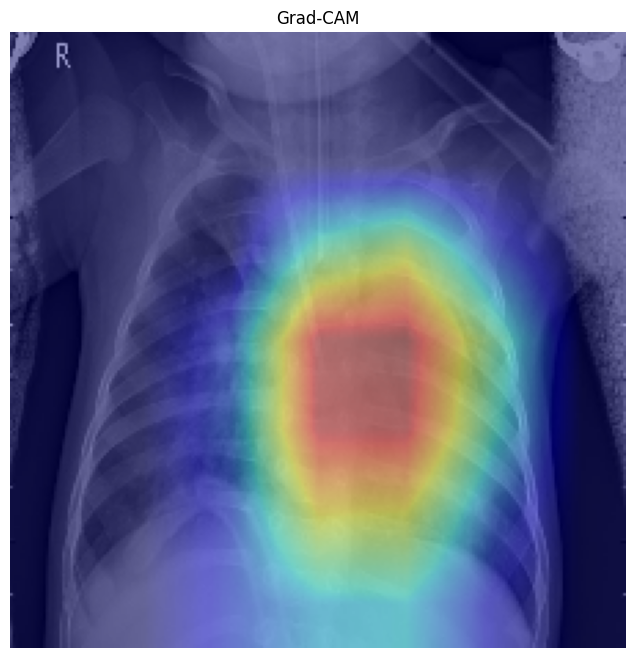

In [28]:
gradcam_on_image(248, test_images, model_2, processed_test_images, IMG_SIZE)

(np.float64(-0.5), np.float64(967.5), np.float64(711.5), np.float64(-0.5))

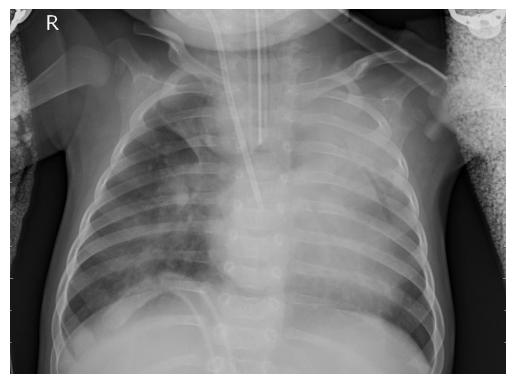

In [29]:
 img = Image.open(test_images[248])

plt.imshow(img, cmap="gray")
plt.axis("off")

# **Analyze False nagative cases (Pneumonia but Normal was predicted)**

In [37]:
print(false_negative_cases)
print('Prediction prob for false nagative cases: ')
print(pred_probs[false_negative_cases])

[245 291 373 462 544 547 584]
Prediction prob for false nagative cases: 
[[0.44598088]
 [0.2720518 ]
 [0.59347063]
 [0.20163798]
 [0.45547417]
 [0.2517482 ]
 [0.00183536]]


The prediction probability is very low for case 2, 4, 5. which means that the model is very confident that these samples are normal but infact they are pneumonia. Let's analyze these cases!

In [40]:
test_images[false_negative_cases]

array(['/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person16_virus_47.jpeg',
       '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person118_bacteria_560.jpeg',
       '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person72_virus_133.jpeg',
       '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person88_bacteria_439.jpeg',
       '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person119_bacteria_568.jpeg',
       '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person153_bacteria_726.jpeg',
       '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person154_bacteria_728.jpeg'],
      dtype='<U88')

In [53]:
#check how many file names in test_images contain bacteria and how many contain virus word
bacteria_count = 0
virus_count = 0
for i in test_images:
  if 'bacteria' in i:
    bacteria_count += 1
  elif 'virus' in i:
    virus_count += 1
print('Bacteria count: ', bacteria_count)
print('Virus count: ', virus_count)

Bacteria count:  242
Virus count:  148


All false nagative cases belong to bacteria caused pneumonia group

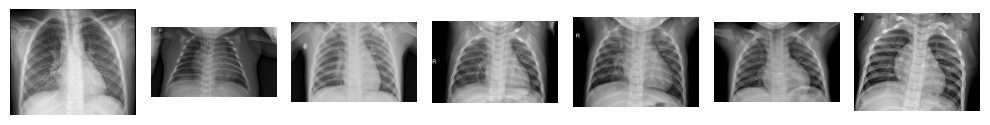

In [54]:
plt.figure(figsize=(10,8))
for j in range(len(false_negative_cases)):

  img_path = test_images[false_negative_cases[j]]
  img = Image.open(img_path)

  plt.subplot(1, len(false_negative_cases), j+1)
  plt.imshow(img, cmap="gray")
  plt.axis("off")

plt.tight_layout()
plt.show()

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

2026-02-09 16:03:44.736865: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━

2026-02-09 16:03:49.868257: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━

2026-02-09 16:03:54.902093: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

2026-02-09 16:03:59.966513: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

2026-02-09 16:04:05.093873: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


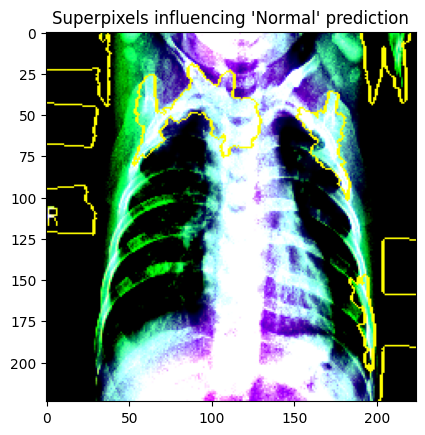

In [57]:
#use LIME explaination for false negative cases
def predict_fn(images):
    return model_2.predict(images)

explainer = lime_image.LimeImageExplainer()
segmentation_fn = lambda x: skimage.segmentation.slic(x, n_segments=100, compactness=10)
explanation = explainer.explain_instance(
    image=processed_test_images[462],
    classifier_fn=predict_fn,
    top_labels=2,  # For binary classification
    hide_color=0,  # Use black or mean pixel value for masking
    num_samples=1500,
    segmentation_fn=segmentation_fn
)
temp, mask = explanation.get_image_and_mask(
    label=0,  # index of "normal" class
    positive_only=True,
    num_features=10,  # number of superpixels to highlight
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title("Superpixels influencing 'Normal' prediction")
plt.show()

(np.float64(-0.5), np.float64(1511.5), np.float64(990.5), np.float64(-0.5))

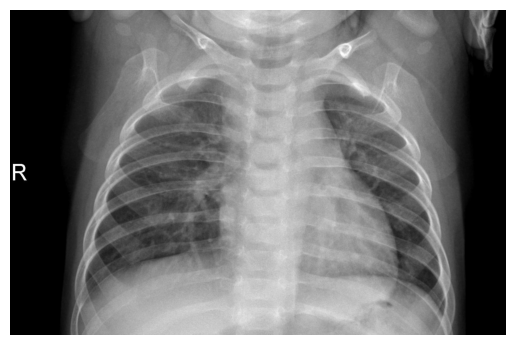

In [58]:
img = Image.open(test_images[462])

plt.imshow(img, cmap="gray")
plt.axis("off")

From the image above, it is clear that the model is looking at background pixels when making the decision

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2026-02-09 16:05:29.555475: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

2026-02-09 16:05:34.664520: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━

2026-02-09 16:05:39.761157: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

2026-02-09 16:05:44.828458: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━

2026-02-09 16:05:49.842465: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


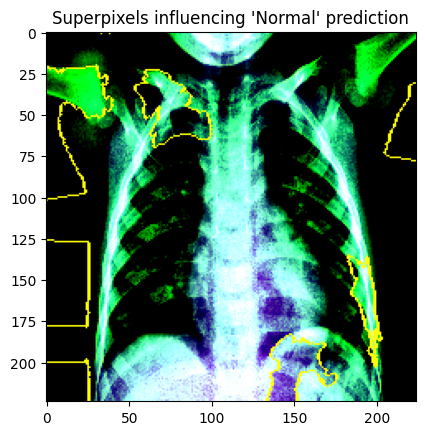

In [59]:
explanation = explainer.explain_instance(
    image=processed_test_images[547],
    classifier_fn=predict_fn,
    top_labels=2,  # For binary classification
    hide_color=0,  # Use black or mean pixel value for masking
    num_samples=1500,
    segmentation_fn=segmentation_fn
)
temp, mask = explanation.get_image_and_mask(
    label=0,  # index of "normal" class
    positive_only=True,
    num_features=10,  # number of superpixels to highlight
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title("Superpixels influencing 'Normal' prediction")
plt.show()

(np.float64(-0.5), np.float64(975.5), np.float64(631.5), np.float64(-0.5))

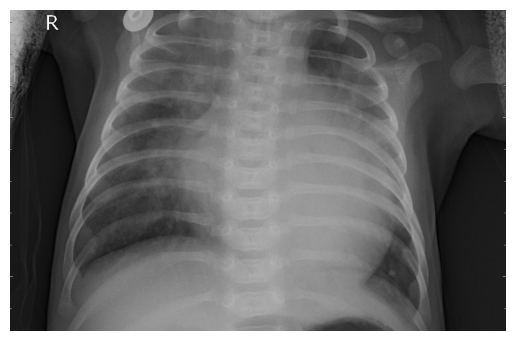

In [63]:
img = Image.open(test_images[437])

plt.imshow(img, cmap="gray")
plt.axis("off")

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

2026-02-09 16:05:54.989111: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━

2026-02-09 16:06:00.059765: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

2026-02-09 16:06:05.157934: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━

2026-02-09 16:06:10.263427: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


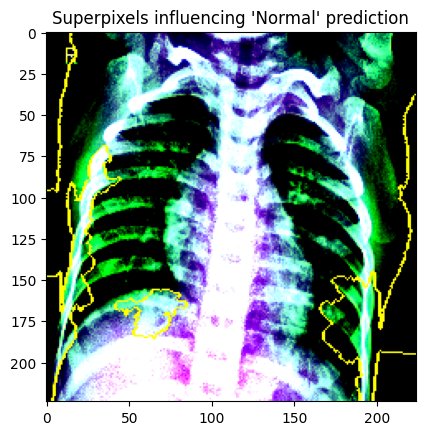

In [61]:
explanation = explainer.explain_instance(
    image=processed_test_images[584],
    classifier_fn=predict_fn,
    top_labels=2,  # For binary classification
    hide_color=0,  # Use black or mean pixel value for masking
    num_samples=1500,
    segmentation_fn=segmentation_fn
)
temp, mask = explanation.get_image_and_mask(
    label=0,  # index of "normal" class
    positive_only=True,
    num_features=10,  # number of superpixels to highlight
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title("Superpixels influencing 'Normal' prediction")
plt.show()

(np.float64(-0.5), np.float64(1557.5), np.float64(1217.5), np.float64(-0.5))

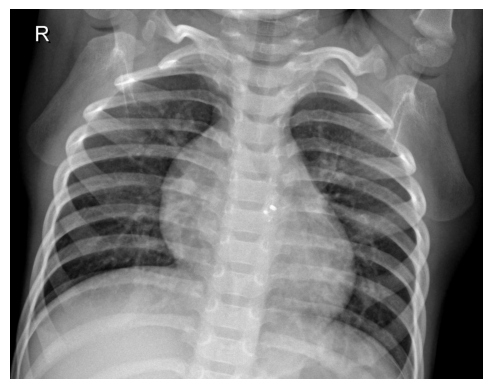

In [62]:
img = Image.open(test_images[584])

plt.imshow(img, cmap="gray")
plt.axis("off")

# **Factors that affect the consistency of the model results**
|    Source of Variability                   |      Description         |Solution  |
| ---|  ---|  ---|
|   Weight Initialization                 |      Random starting weights for DenseNet121            |  kernel_initializer=GlorotUniform(seed=42)  |
|   Data Shuffling                 |      Random order of samples each epoch            | 	 tf.config.experimental.enable_op_determinism()   |
|  Data Augmentation                |     Random image transformations (flips, rotations, etc.) per epoch  |  ImageDataGenerator().flow(,...seed=42)  |
|  Dropout Layer                |      Randomly disables neurons during training  |  	layers.Dropout(0.3, seed=42)  |
|   Class-Weighted Loss               |    Interacts with batch composition and augmentation, affecting learning dynamics        |  use the same class weight parameters  |
|  Random Number Generators               |      Python, NumPy, TensorFlow/Keras, and possibly CUDA          |   random.seed(42), 	np.random.seed(42), tf.random.set_seed(42)  |
|  GPU/Hardware Non-Determinism	             |     	Floating-point, atomic, and parallel ops on GPU; cuDNN/CUDA auto-tuning        |   Use the same GPU |

